In [4]:
# READ ME FIRST!
# Run code from top to bottom as it appears for successful execution
# Step 1. loading dataset and preprocessing
#
# Import required libraries
import os
import pandas as pd
import cv2 
from tqdm import tqdm 

# Define the dataset directory and CSV file path
dataset_dir = "MR-image-Dataset/"
csv_path = "data.csv"

# Load the CSV file containing patient's data
data_info = pd.read_csv(csv_path)

# Remove the date suffix from the patient folder names to match the patient column in the CSV
def extract_patient_id(folder_name):
    return '_'.join(folder_name.split('_')[:3])

# Function to get the full image filename without the mask suffix
def get_image_number(file_name):
    # If it's a mask file, remove the '_mask' suffix
    if 'mask' in file_name:
        return file_name.replace('_mask', '')
    return file_name

# Create lists to store the image and mask file paths and tumor labels
patient_ids = []
image_files = []
mask_files = []
tumor_labels = []

# Go thru all patient folders
for patient_folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, patient_folder)

    # Check if the current item is a directory
    if os.path.isdir(folder_path):
        patient_id = extract_patient_id(patient_folder)
        print(f"Processing patient folder: {patient_folder} (Patient ID: {patient_id})")

        # Temp dictionary to store image-mask pairs for this patient
        temp_images = {}
        temp_masks = {}

        # Separate images and masks for each patient based on their full file name
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            image_number = get_image_number(file_name)
            
            if 'mask' in file_name:
                temp_masks[image_number] = file_path
                print(f"Found mask: {file_name} (Image number: {image_number})")
            else:
                temp_images[image_number] = file_path
                print(f"Found image: {file_name} (Image number: {image_number})")

        # Match images and masks based on the exact file name
        for image_number, image_path in temp_images.items():
            if image_number in temp_masks:
                mask_path = temp_masks[image_number]
                
                # Try reading the mask image
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                # Labelling if they have a tumor or not
                if mask is None:
                    tumor_labels.append('No Tumor')
                elif mask.sum() > 0:
                    tumor_labels.append('Has Tumor')
                else:
                    tumor_labels.append('No Tumor')

                # Store the matched image and mask paths
                image_files.append(image_path)
                mask_files.append(mask_path)
                patient_ids.append(patient_id)
                print(f"Matched image {image_path} with mask {mask_path}")
            else:
                print(f"Warning: No matching mask found for image {image_path} of patient {patient_id}")

# Check again if lengths match
if len(image_files) == len(mask_files) == len(patient_ids) == len(tumor_labels):
    
    # Create a DataFrame with the image and mask paths and tumor labels
    image_data = pd.DataFrame({
        'Patient_ID': patient_ids,
        'Image_Path': image_files,
        'Mask_Path': mask_files,
        'Tumor_Label': tumor_labels
        
    })

    # Merge with the additional information from the CSV saving as new dataset
    final_dataset = pd.merge(image_data, data_info, left_on='Patient_ID', right_on='Patient', how='left')

    # Show the final dataset
    print(final_dataset.head())

    # Save the final dataset to CSV
    final_csv_path = "MR-image-Dataset/final_dataset.csv"
    final_dataset.to_csv(final_csv_path, index=False)
    print(f"Final dataset saved to {final_csv_path}")
else:
    print("Mismatch in the number of images, masks, patient IDs, or tumor labels.")


Processing patient folder: .ipynb_checkpoints (Patient ID: .ipynb_checkpoints)
Processing patient folder: TCGA_CS_4941_19960909 (Patient ID: TCGA_CS_4941)
Found image: TCGA_CS_4941_19960909_1.tif (Image number: TCGA_CS_4941_19960909_1.tif)
Found image: TCGA_CS_4941_19960909_10.tif (Image number: TCGA_CS_4941_19960909_10.tif)
Found mask: TCGA_CS_4941_19960909_10_mask.tif (Image number: TCGA_CS_4941_19960909_10.tif)
Found image: TCGA_CS_4941_19960909_11.tif (Image number: TCGA_CS_4941_19960909_11.tif)
Found mask: TCGA_CS_4941_19960909_11_mask.tif (Image number: TCGA_CS_4941_19960909_11.tif)
Found image: TCGA_CS_4941_19960909_12.tif (Image number: TCGA_CS_4941_19960909_12.tif)
Found mask: TCGA_CS_4941_19960909_12_mask.tif (Image number: TCGA_CS_4941_19960909_12.tif)
Found image: TCGA_CS_4941_19960909_13.tif (Image number: TCGA_CS_4941_19960909_13.tif)
Found mask: TCGA_CS_4941_19960909_13_mask.tif (Image number: TCGA_CS_4941_19960909_13.tif)
Found image: TCGA_CS_4941_19960909_14.tif (Image

Visualizing for Patient ID: TCGA_CS_4941 (Tumor: No Tumor)


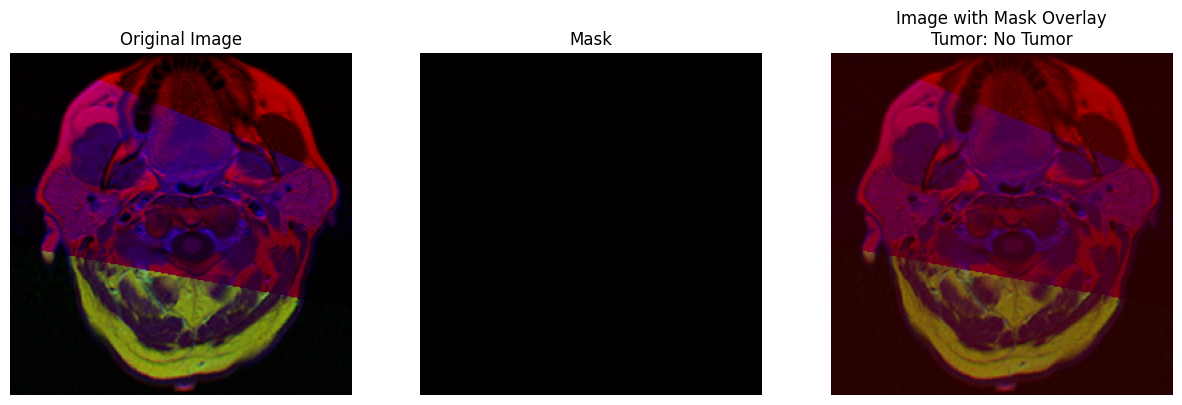

Visualizing for Patient ID: TCGA_CS_4941 (Tumor: No Tumor)


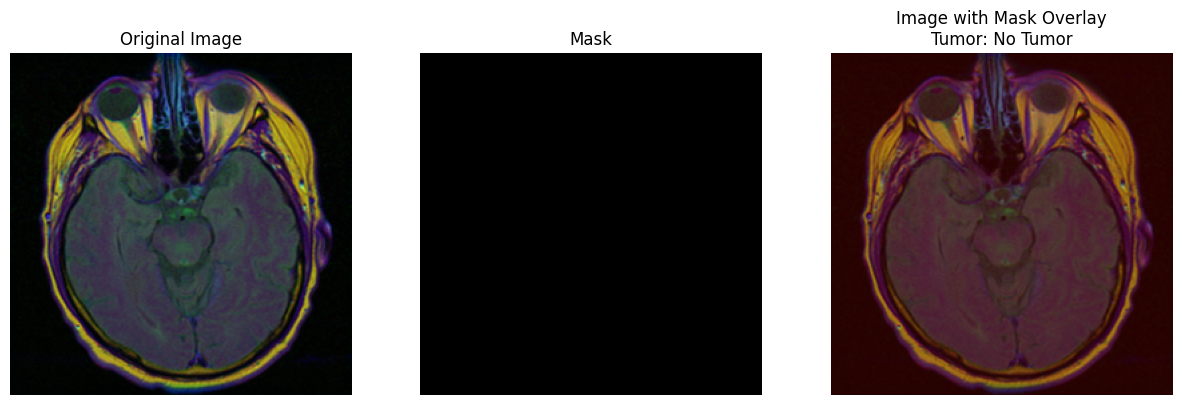

Visualizing for Patient ID: TCGA_CS_4941 (Tumor: Has Tumor)


Visualizing for Patient ID: TCGA_CS_4941 (Tumor: Has Tumor)


Visualizing for Patient ID: TCGA_CS_4941 (Tumor: Has Tumor)


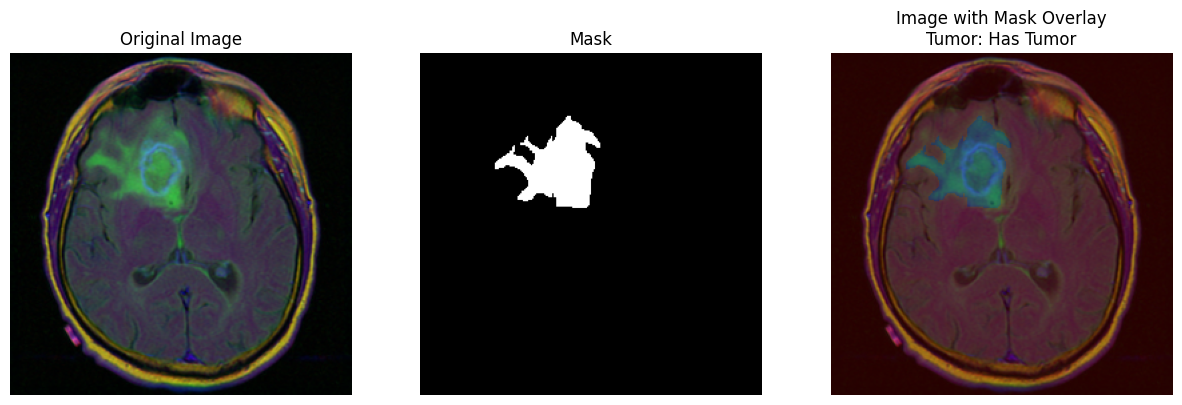

In [5]:
# Step 2. Visualizing images
#
# Import required libraries
import os
import cv2
import matplotlib.pyplot as plt

# Function to visualize original image, mask, and overlay with tumor annotation
def visualize_image_and_mask(image_path, mask_path, tumor_label):
    # Read the original image in color
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    # Convert from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the mask in grayscale
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Create a color map for the mask
    mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)

    # Overlay the mask on the original image
    overlay = cv2.addWeighted(image, 0.7, mask_colored, 0.3, 0)

    # Plot the images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Mask')
    axs[1].axis('off')

    axs[2].imshow(overlay)
    axs[2].set_title(f'Image with Mask Overlay\nTumor: {tumor_label}')  # Annotating whether there is a tumor
    axs[2].axis('off')

    plt.show()

# Visualize 5 images and their masks with tumor annotation
for i in range(5):
    image_path = final_dataset['Image_Path'].iloc[i]
    mask_path = final_dataset['Mask_Path'].iloc[i]
    tumor_label = final_dataset['Tumor_Label'].iloc[i]  # Get the tumor label from the dataset
    print(f"Visualizing for Patient ID: {final_dataset['Patient_ID'].iloc[i]} (Tumor: {tumor_label})")
    visualize_image_and_mask(image_path, mask_path, tumor_label)


In [6]:
# Step 3. Splitting images to Train, Val, Test
#
# Import required libraries
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the final dataset
final_dataset = pd.read_csv('MR-image-Dataset/final_dataset.csv')

# Define the split ratios
train_size = 0.8  # 80% for training
val_test_size = 0.1  # 10% each for validation and test

# Split the dataset into train + (VAL + TEST)
train_data, val_test_data = train_test_split(final_dataset, test_size=(val_test_size * 2), random_state=42, stratify=final_dataset['Tumor_Label'])

# Split the (VAL + TEST) dataset into VAL and TEST
# Stratify to ensure even split between sets
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42, stratify=val_test_data['Tumor_Label'])

# Display the size of each split
print(f"Train dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")
print(f"Test dataset size: {len(test_data)}")

# Save the datasets to CSV files
train_data.to_csv('MR-image-Dataset/train_dataset.csv', index=False)
val_data.to_csv('MR-image-Dataset/val_dataset.csv', index=False)
test_data.to_csv('MR-image-Dataset/test_dataset.csv', index=False)

print("Datasets saved successfully!")


Train dataset size: 3143
Validation dataset size: 393
Test dataset size: 393
Datasets saved successfully!


In [7]:
# Step 4. Loading images
#
# Import required libraries
import numpy as np

# Load the final dataset
try:
    final_dataset = pd.read_csv('MR-image-Dataset/final_dataset.csv')
    print("Final dataset loaded successfully.")
# If fails
except FileNotFoundError:
    print("Error: final_dataset.csv not found.")
    raise

# Load images and masks based on the paths in the dataset
def load_images_and_masks(data):
    images = []  # List to store loaded images
    masks = []   # List to store loaded masks
    # Cycle thru each row
    for index, row in data.iterrows():
        try:
            # Load the image and mask based on the paths from your dataset
            img = cv2.imread(row['Image_Path'])
            mask = cv2.imread(row['Mask_Path'], cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"Warning: Image at index {index} could not be loaded from path: {row['Image_Path']}")
                continue
            if mask is None:
                print(f"Warning: Mask at index {index} could not be loaded from path: {row['Mask_Path']}")
                continue
            
            images.append(img)
            masks.append(mask[..., np.newaxis])

            # Print every 10 images for progress tracking
            if index % 10 == 0: 
                print(f"Loaded and resized image and mask for index {index}.")
        
        except Exception as e:
            print(f"Error processing index {index}: {e}")
            continue

    print(f"Total images loaded: {len(images)}")
    print(f"Total masks loaded: {len(masks)}")
    
    return np.array(images), np.array(masks)

try:
    X_train, y_train = load_images_and_masks(train_data)
    X_val, y_val = load_images_and_masks(val_data)
    print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
    print(f"Validation data shapes: {X_val.shape}, {y_val.shape}")
except Exception as e:
    print(f"Error loading images and masks: {e}")
    raise

Final dataset loaded successfully.
Loaded and resized image and mask for index 1100.
Loaded and resized image and mask for index 660.
Loaded and resized image and mask for index 2540.
Loaded and resized image and mask for index 980.
Loaded and resized image and mask for index 1760.
Loaded and resized image and mask for index 1540.
Loaded and resized image and mask for index 1910.
Loaded and resized image and mask for index 3550.
Loaded and resized image and mask for index 450.
Loaded and resized image and mask for index 490.
Loaded and resized image and mask for index 1970.
Loaded and resized image and mask for index 2580.
Loaded and resized image and mask for index 2900.
Loaded and resized image and mask for index 130.
Loaded and resized image and mask for index 360.
Loaded and resized image and mask for index 3290.
Loaded and resized image and mask for index 2370.
Loaded and resized image and mask for index 1180.
Loaded and resized image and mask for index 3500.
Loaded and resized im

In [8]:
# Step 5. Checking GPU and CUDA is usable for training
#
# Import required libraries
import torch

# Checking and loading CUDA for GPU usage
if torch.cuda.is_available():
    print(f"CUDA is available. Device name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("CUDA is not available.")


CUDA is available. Device name: NVIDIA GeForce RTX 4060 Ti
Number of GPUs: 1


In [9]:
# Step 5. Loading images with augmentation
#
# Import required libraries
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torchvision.transforms as transform
import pandas as pd
from torchvision import transforms

# Define the image augmentation transformations
train_transform_image = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256 (not really needed as all images are 256)
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(30),  # Randomly rotate images by up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, etc.
    transforms.ToTensor(),            # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize RGB images
])

# Define the transformations for validation and testing
val_transform_image = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),            # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize RGB images
])

# Define the transformations for masks
transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize masks to 256x256
    transforms.ToTensor(),            # Convert PIL Image to Tensor
]) 

# Define a class for the TumorDatasets
class TumorDataset(Dataset):
    def __init__(self, dataframe, transform_image=None, transform_mask=None):
        self.dataframe = dataframe
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the image and mask paths from the dataframe
        img_path = self.dataframe.iloc[idx]['Image_Path']
        mask_path = self.dataframe.iloc[idx]['Mask_Path']

        # Load the image and mask
        image = Image.open(img_path).convert("RGB")  # RGB images
        mask = Image.open(mask_path).convert("L")    # Grayscale masks

        # Apply the transformations if specified
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask


# Load the datasets
train_df = pd.read_csv('MR-image-Dataset/train_dataset.csv')
val_df = pd.read_csv('MR-image-Dataset/val_dataset.csv')
test_df = pd.read_csv('MR-image-Dataset/test_dataset.csv')

# Create dataset objects
train_dataset = TumorDataset(train_df, transform_image=train_transform_image, transform_mask=transform_mask)
val_dataset = TumorDataset(val_df, transform_image=val_transform_image, transform_mask=transform_mask)
test_dataset = TumorDataset(test_df, transform_image=val_transform_image, transform_mask=transform_mask)

# Create DataLoaders, increased num_workers for speed
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [10]:
# Step 6. Defining DICE functions
#
# Import required libraries
import torch.optim as optim

# Dice loss function
def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)  # Convert logits to probabilities
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

# Combined loss: BCE + Dice loss
def combined_loss(pred, target):
    bce_loss = nn.BCEWithLogitsLoss()(pred, target)
    return bce_loss + dice_loss(pred, target)


In [11]:
# Step 6. Defining model
#
# Import required libraries
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define model using a pretrained encoder (resnet34)
class PretrainedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, encoder_name="resnet34", encoder_weights="imagenet"):
        super(PretrainedUNet, self).__init__()
        
        # Use the UNet model from segmentation_models_pytorch
        self.unet = smp.Unet(
            encoder_name=encoder_name,        
            encoder_weights=encoder_weights,  
            in_channels=in_channels,          
            classes=out_channels              
        )

    def forward(self, x):
        return self.unet(x)

model = PretrainedUNet(in_channels=3, out_channels=1)  
sample_input = torch.randn(1, 3, 256, 256)  
output = model(sample_input)
print("Output shape:", output.shape)


C:\Users\maxpr\anaconda3\envs\GPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Output shape: torch.Size([1, 1, 256, 256])


In [ ]:
# Step 7. Training model. Don't run this code! Skip ahead to load model from this code 
#
# Import required libraries
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import random
import segmentation_models_pytorch as smp
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

# Tversky Loss function
def tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5, smooth=0.0001):
    true_pos = (y_true * y_pred).sum()
    false_neg = (y_true * (1 - y_pred)).sum()
    false_pos = ((1 - y_true) * y_pred).sum()
    
    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
    return 1 - tversky

# Focal Tversky Loss function
def focal_tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5, gamma=2, smooth=0.0001):
    true_pos = (y_true * y_pred).sum()
    false_neg = (y_true * (1 - y_pred)).sum()
    false_pos = ((1 - y_true) * y_pred).sum()
    
    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
    focal_tversky = (1 - tversky) ** gamma
    return focal_tversky
    
# Custom CombinedLoss (Dice + BCE)
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight

    def forward(self, outputs, targets):
        dice_loss = self.dice_loss(outputs, targets)
        bce_loss = self.bce_loss(outputs, targets)
        return self.dice_weight * dice_loss + self.bce_weight * bce_loss

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping triggered after {self.patience} epochs.")
                    
metrics = {
    "train_loss": [],
    "val_loss": [],
    "train_dice": [],
    "val_dice": [],
    "train_tversky": [],
    "val_tversky": [],
    "train_focal_tversky": [],
    "val_focal_tversky": [],
}

# Training hyperparameters
num_epochs = 50
learning_rate = 0.0001
batch_size = 8
validation_freq = 1

# Model setup
model = PretrainedUNet(in_channels=3, out_channels=1, encoder_name="resnet34")

# Move the model to GPU
model = model.cuda()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Custom CombinedLoss
loss_fn = CombinedLoss(dice_weight=0.5, bce_weight=0.5)

# Mixed precision training setup
scaler = GradScaler()

# Train and validation DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a subset of the validation set
val_size = int(0.3 * len(val_dataset))
indices = random.sample(range(len(val_dataset)), val_size)
val_subset = Subset(val_dataset, indices)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# Training function with mixed precision
def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn, scaler):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader):
        images, masks = images.cuda(), masks.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Mixed precision training
        with autocast():
            # Forward pass
            outputs = model(images)
            # Compute loss
            loss = loss_fn(outputs, masks)
        
        # Backward pass with scaled gradients
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}")

# Dice coefficient function
def dice_coefficient(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()  
    true_mask = (true_mask > threshold).float()  
    
    intersection = (pred_mask * true_mask).sum()
    
    # Calculate union
    union = pred_mask.sum() + true_mask.sum()  

    if union == 0:
        # Both masks are empty
        return 1.0  

    dice = (2. * intersection) / union
    return dice.item()

# Validation function with mixed precision
def validate_one_epoch(epoch, model, val_loader, loss_fn):
    model.eval()
    running_val_loss = 0.0
    dice_scores = []
    avg_tversky_scores = []
    avg_focal_tversky_scores = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images, masks = images.cuda(), masks.cuda()

            # Mixed precision for validation
            with autocast():  
                # Forward pass
                outputs = model(images)
                # Compute validation loss
                val_loss = loss_fn(outputs, masks)
                running_val_loss += val_loss.item() * images.size(0)

            # Calculate Dice score for evaluation
            predicted_masks = torch.sigmoid(outputs)  
            for pred_mask, true_mask in zip(predicted_masks, masks):
                dice_score = dice_coefficient(pred_mask, true_mask)
                dice_scores.append(dice_score)
                
                # Calculate Tversky and Focal Tversky losses
                tversky = tversky_loss(true_mask, pred_mask).item()  
                focal_tversky = focal_tversky_loss(true_mask, pred_mask).item()  #
                
                avg_tversky_scores.append(tversky)
                avg_focal_tversky_scores.append(focal_tversky)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    avg_dice_score = sum(dice_scores) / len(dice_scores) if dice_scores else 0
    avg_tversky = sum(avg_tversky_scores) / len(avg_tversky_scores) if avg_tversky_scores else 0
    avg_focal_tversky = sum(avg_focal_tversky_scores) / len(avg_focal_tversky_scores) if avg_focal_tversky_scores else 0

    # Store metrics
    metrics["val_loss"].append(epoch_val_loss)
    metrics["val_dice"].append(avg_dice_score)
    metrics["val_tversky"].append(avg_tversky)
    metrics["val_focal_tversky"].append(avg_focal_tversky)

    print(f"Epoch {epoch+1}, Validation Loss: {epoch_val_loss:.4f}, Average Dice Score: {avg_dice_score:.4f}, Tversky Loss: {avg_tversky:.4f}, Focal Tversky Loss: {avg_focal_tversky:.4f}")
    return epoch_val_loss


# Instantiate early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train for one epoch
    train_one_epoch(epoch, model, train_loader, optimizer, loss_fn, scaler)
    
    # Perform validation every validation_freq epochs
    if epoch % validation_freq == 0:
        val_loss = validate_one_epoch(epoch, model, val_loader, loss_fn)
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

# Save the final model
#torch.save(model.state_dict(), "pretrained_unet_resnet34.pth")

In [12]:
# Step 8. Loading model
#
# Import libraries
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch

# Initialize model and move to GPU
model = PretrainedUNet().cuda()

# Load the saved model weights
model.load_state_dict(torch.load('pretrained_unet_resnet34.pth'))

# Set the model to evaluation mode
model.eval()

# Initialize optimizer with the same learning rate used during training
optimizer = optim.Adam(model.parameters(), lr=0.0001)



C:\Users\maxpr\AppData\Local\Temp\ipykernel_89476\3452784379.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pretrained_unet_resnet34.

In [13]:
# Step 9. loading training metrics and graphing them (may only work if model was trained not loaded)
#
# Import libraries
import matplotlib.pyplot as plt

val_epochs = list(range(1, len(metrics["val_loss"]) * validation_freq + 1, validation_freq))

plt.figure(figsize=(12, 10))

# Plot Validation Loss
plt.subplot(4, 1, 1)
plt.plot(val_epochs, metrics["val_loss"], label="Validation Loss", color='blue')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Dice Coefficient
plt.subplot(4, 1, 2)
plt.plot(val_epochs, metrics["val_dice"], label="Dice Coefficient", color='green')
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.legend()

# Plot Tversky Loss separately
plt.subplot(4, 1, 3)
plt.plot(val_epochs, metrics["val_tversky"], label="Tversky Loss", color='orange')
plt.title("Tversky Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Focal Tversky Loss separately
plt.subplot(4, 1, 4)
plt.plot(val_epochs, metrics["val_focal_tversky"], label="Focal Tversky Loss", color='red')
plt.title("Focal Tversky Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'metrics' is not defined

In [14]:
# Step 10. calculate tumor area and true tumor area
#
# Function to calculate tumor area from a mask
def calculate_tumor_area(mask):
    return (mask > 0.5).sum().item() 

# Evaluate on test data and calculate both predicted and true tumor areas
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.cuda()
        outputs = model(images)
        predicted_masks = torch.sigmoid(outputs).cpu()
        
        for i, (pred_mask, true_mask) in enumerate(zip(predicted_masks, masks)):
            # Calculate the predicted tumor area
            predicted_tumor_area = calculate_tumor_area(pred_mask)
            
            # Calculate the true tumor area
            true_tumor_area = calculate_tumor_area(true_mask)

            # Print the predicted and true tumor areas for each image
            print(f"Image {i+1}: Predicted Tumor Area = {predicted_tumor_area} pixels, True Tumor Area = {true_tumor_area} pixels")


Image 1: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 2: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 3: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 4: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 5: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 6: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 7: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 8: Predicted Tumor Area = 1319 pixels, True Tumor Area = 735 pixels
Image 9: Predicted Tumor Area = 4351 pixels, True Tumor Area = 3123 pixels
Image 10: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 11: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 12: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 13: Predicted Tumor Area = 1188 pixels, True Tumor Area = 840 pixels
Image 14: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 15: Pre

In [15]:
# Step 11. More DICE
#
# Function to calculate the Dice Coefficient
def dice_coefficient(pred_mask, true_mask, threshold=0.5):
    # Binarize the masks
    pred_mask = (pred_mask > threshold).float()  
    true_mask = (true_mask > threshold).float()  
    
    # Calculate intersection
    intersection = (pred_mask * true_mask).sum()
    
    # Calculate union
    union = pred_mask.sum() + true_mask.sum()  

    if union == 0:
        # Both masks are empty
        return 1.0  

    dice = (2. * intersection) / union
    return dice.item()

# Calculate the Dice score
for i, (pred_mask, true_mask) in enumerate(zip(predicted_masks, masks)):
    dice_score = dice_coefficient(pred_mask, true_mask)
    print(f"Image {i+1}: Dice Coefficient = {dice_score:.4f}")


Image 1: Dice Coefficient = 1.0000
Image 2: Dice Coefficient = 0.0000
Image 3: Dice Coefficient = 1.0000
Image 4: Dice Coefficient = 1.0000
Image 5: Dice Coefficient = 0.7782
Image 6: Dice Coefficient = 1.0000
Image 7: Dice Coefficient = 0.6953
Image 8: Dice Coefficient = 1.0000
Image 9: Dice Coefficient = 1.0000


Image 1: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 1: Dice Coefficient = 1.0000
Image 2: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 2: Dice Coefficient = 1.0000
Image 3: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 3: Dice Coefficient = 1.0000
Image 4: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 4: Dice Coefficient = 1.0000
Image 5: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 5: Dice Coefficient = 1.0000
Image 6: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 6: Dice Coefficient = 1.0000
Image 7: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 7: Dice Coefficient = 1.0000
Image 8: Predicted Tumor Area = 1319 pixels, True Tumor Area = 735 pixels
Image 8: Dice Coefficient = 0.5492
Image 9: Predicted Tumor Area = 4351 pixels, True Tumor Area = 3123 pixels
Image 9: Dice Coefficient = 0.8282
Image 10: Predicted Tumor Area = 0 pixels, True Tumor

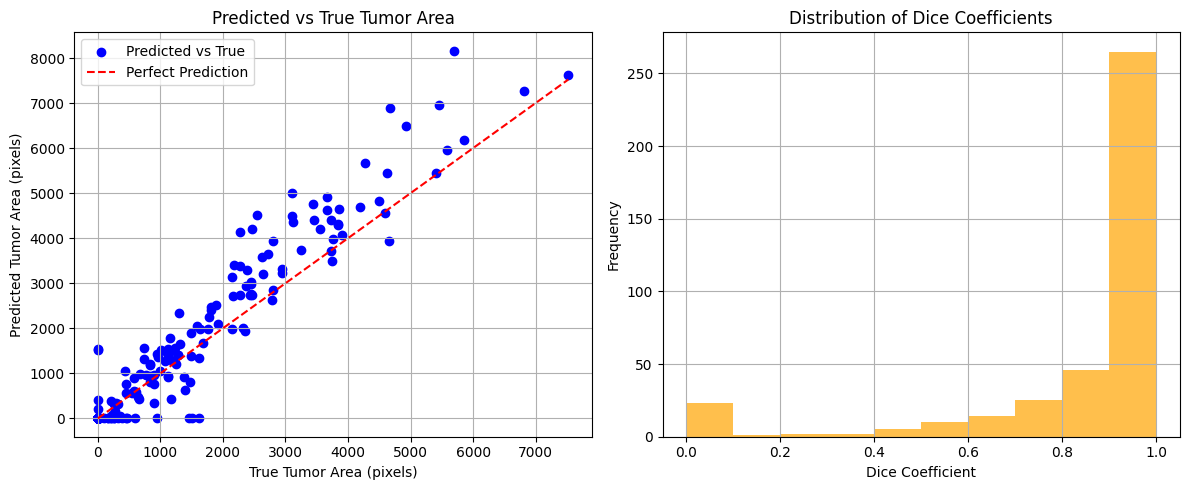

In [16]:
# Step 12. More DICE & areas by pixel. full list
#
# Required libraries
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store tumor areas and Dice scores
predicted_areas = []
true_areas = []
dice_scores = []

# Evaluate on test data and calculate both predicted and true tumor areas
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.cuda()
        outputs = model(images)
        predicted_masks = torch.sigmoid(outputs).cpu()
        
        for i, (pred_mask, true_mask) in enumerate(zip(predicted_masks, masks)):
            # Calculate the predicted tumor area
            predicted_tumor_area = calculate_tumor_area(pred_mask)
            predicted_areas.append(predicted_tumor_area)
            
            # Calculate the true tumor area
            true_tumor_area = calculate_tumor_area(true_mask)
            true_areas.append(true_tumor_area)

            # Calculate the Dice score
            dice_score = dice_coefficient(pred_mask, true_mask)
            dice_scores.append(dice_score)

            # Print the predicted and true tumor areas for each image
            print(f"Image {i + 1}: Predicted Tumor Area = {predicted_tumor_area} pixels, True Tumor Area = {true_tumor_area} pixels")
            print(f"Image {i + 1}: Dice Coefficient = {dice_score:.4f}")

# Convert lists to numpy arrays for easier calculations
predicted_areas = np.array(predicted_areas)
true_areas = np.array(true_areas)
dice_scores = np.array(dice_scores)

# Calculate accuracy metrics
mae = np.mean(np.abs(predicted_areas - true_areas))  # Mean Absolute Error
mse = np.mean((predicted_areas - true_areas) ** 2)  # Mean Squared Error
r_squared = 1 - (np.sum((predicted_areas - true_areas) ** 2) / np.sum((true_areas - np.mean(true_areas)) ** 2))  # R-squared

# Print accuracy metrics
print(f"\nMean Absolute Error (MAE): {mae:.2f} pixels")
print(f"Mean Squared Error (MSE): {mse:.2f} pixels")
print(f"R-squared Score: {r_squared:.4f}")

# Function to calculate the Dice Coefficient
def dice_coefficient(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()  # Binarize the prediction
    true_mask = (true_mask > threshold).float()  # Binarize the true mask
    
    intersection = (pred_mask * true_mask).sum()  # Calculate intersection
    union = pred_mask.sum() + true_mask.sum()  # Calculate union

    if union == 0:
        return 1.0  # Both masks are empty

    dice = (2. * intersection) / union
    return dice.item()

# Evaluate on test data and calculate the average Dice coefficient
model.eval()
dice_scores = []  # List to hold individual Dice scores
with torch.no_grad():
    for images, masks in test_loader:
        images = images.cuda()
        outputs = model(images)
        predicted_masks = torch.sigmoid(outputs).cpu()  # Apply sigmoid and move to CPU for processing
        
        for pred_mask, true_mask in zip(predicted_masks, masks):
            dice_score = dice_coefficient(pred_mask, true_mask)
            dice_scores.append(dice_score)  # Store the Dice score

# Calculate and print the average Dice Coefficient
average_dice_coefficient = sum(dice_scores) / len(dice_scores) if dice_scores else 0
print(f"Average Dice Coefficient: {average_dice_coefficient:.4f}")

# Visualization
plt.figure(figsize=(12, 5))

# Tumor Areas
plt.subplot(1, 2, 1)
plt.scatter(true_areas, predicted_areas, color='blue', label='Predicted vs True')
plt.plot([0, max(true_areas)], [0, max(true_areas)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('True Tumor Area (pixels)')
plt.ylabel('Predicted Tumor Area (pixels)')
plt.title('Predicted vs True Tumor Area')
plt.legend()
plt.grid()

# Dice Coefficients
plt.subplot(1, 2, 2)
plt.hist(dice_scores, bins=10, color='orange', alpha=0.7)
plt.xlabel('Dice Coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of Dice Coefficients')
plt.grid()

plt.tight_layout()
plt.show()


In [17]:
# Step 13. Tversky Index & Focal Tversky
#
# Function to calculate Tversky
def tversky_index(pred_mask, true_mask, alpha=0.5, beta=0.5, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()  # Binarize the prediction
    true_mask = (true_mask > threshold).float()  # Binarize the true mask

    TP = (pred_mask * true_mask).sum()  # True Positives
    FP = (pred_mask * (1 - true_mask)).sum()  # False Positives
    FN = ((1 - pred_mask) * true_mask).sum()  # False Negatives

    # Avoid division by zero by ensuring we return a float
    tversky = TP / (TP + alpha * FP + beta * FN + 0.0001) 
    return tversky.item()  # Convert to a Python float

# Function to calculate Tversky loss
def focal_tversky_loss(pred_mask, true_mask, alpha=0.5, beta=0.5, gamma=1.0, threshold=0.5):
    tversky = tversky_index(pred_mask, true_mask, alpha, beta, threshold)
    focal_tversky = (1 - tversky) ** gamma
    return focal_tversky

model.eval()
tversky_scores = [] 
focal_tversky_losses = [] 

with torch.no_grad():
    for images, masks in test_loader:
        images = images.cuda()
        outputs = model(images)
        predicted_masks = torch.sigmoid(outputs).cpu()
        
        for pred_mask, true_mask in zip(predicted_masks, masks):
            # Calculate Tversky index
            tversky_score = tversky_index(pred_mask, true_mask)
            tversky_scores.append(tversky_score)  # Store the Tversky score

            # Calculate Focal Tversky loss
            focal_tversky_loss_value = focal_tversky_loss(pred_mask, true_mask)
            focal_tversky_losses.append(focal_tversky_loss_value)  # Store the Focal Tversky loss

            print(f"Tversky Index = {tversky_score:.4f}, Focal Tversky Loss = {focal_tversky_loss_value:.4f}")

# Calculate and print the average Tversky index and Focal Tversky loss
average_tversky = sum(tversky_scores) / len(tversky_scores) if tversky_scores else 0
average_focal_tversky_loss = sum(focal_tversky_losses) / len(focal_tversky_losses) if focal_tversky_losses else 0

print(f"Average Tversky Index: {average_tversky:.4f}")
print(f"Average Focal Tversky Loss: {average_focal_tversky_loss:.4f}")



Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Index = 0.5492, Focal Tversky Loss = 0.4508
Tversky Index = 0.8282, Focal Tversky Loss = 0.1718
Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Index = 0.4822, Focal Tversky Loss = 0.5178
Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Index = 0.7710, Focal Tversky Loss = 0.2290
Tversky Index = 0.8236, Focal Tversky Loss = 0.1764
Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Index = 0.0000, Focal Tversky Loss = 1.0000
Tversky Inde

True Tumor Area for Patient ID TCGA_CS_4941: 0 pixels
Predicted Tumor Area for Patient ID TCGA_CS_4941: 0 pixels
IoU for Patient ID TCGA_CS_4941: 0.0000
Dice Coefficient for Patient ID TCGA_CS_4941: 0.0000
Accuracy for Patient ID TCGA_CS_4941: 1.0000


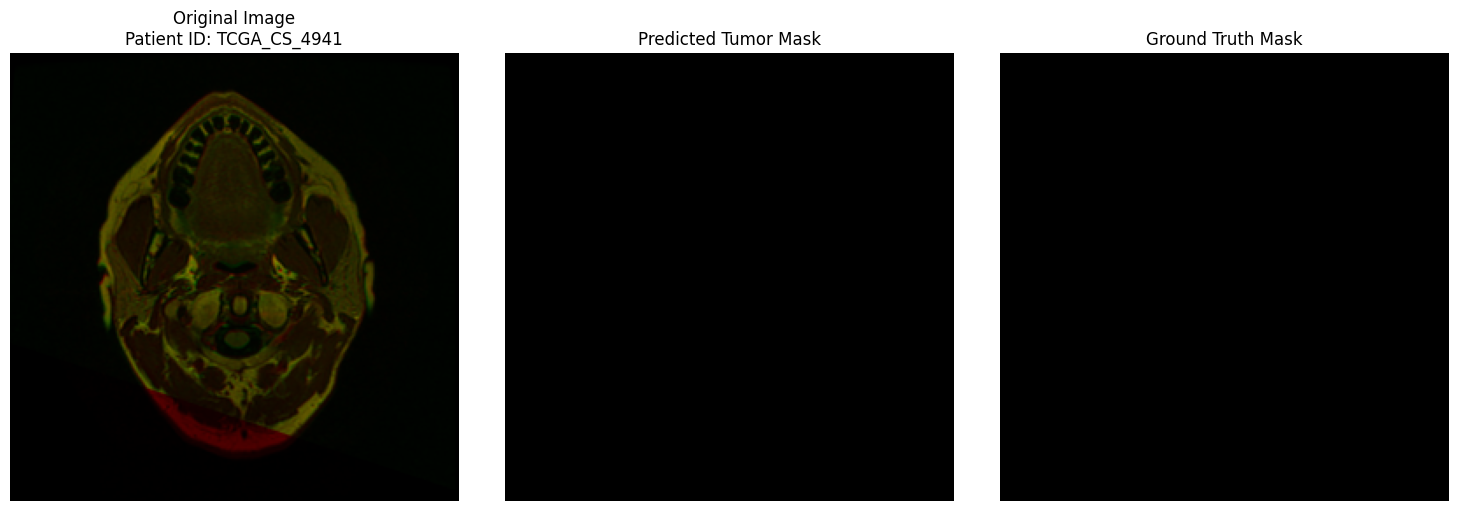

True Tumor Area for Patient ID TCGA_CS_4941: 214 pixels
Predicted Tumor Area for Patient ID TCGA_CS_4941: 0 pixels
IoU for Patient ID TCGA_CS_4941: 0.0000
Dice Coefficient for Patient ID TCGA_CS_4941: 0.0000
Accuracy for Patient ID TCGA_CS_4941: 0.9967


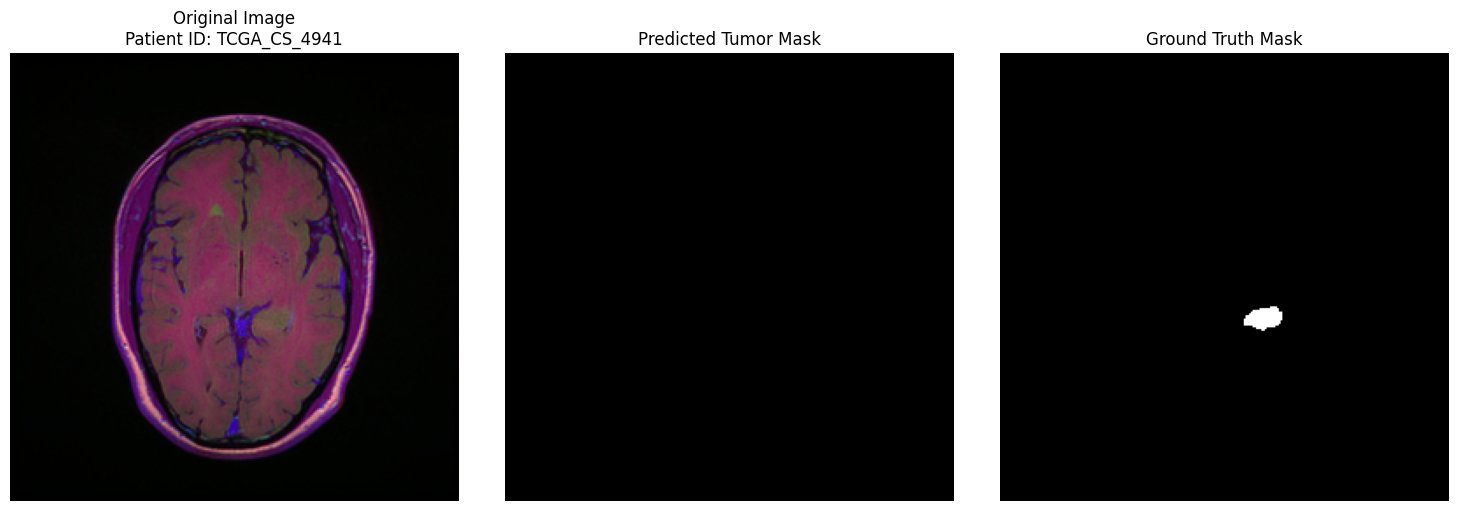

True Tumor Area for Patient ID TCGA_CS_4941: 0 pixels
Predicted Tumor Area for Patient ID TCGA_CS_4941: 0 pixels
IoU for Patient ID TCGA_CS_4941: 0.0000
Dice Coefficient for Patient ID TCGA_CS_4941: 0.0000
Accuracy for Patient ID TCGA_CS_4941: 1.0000


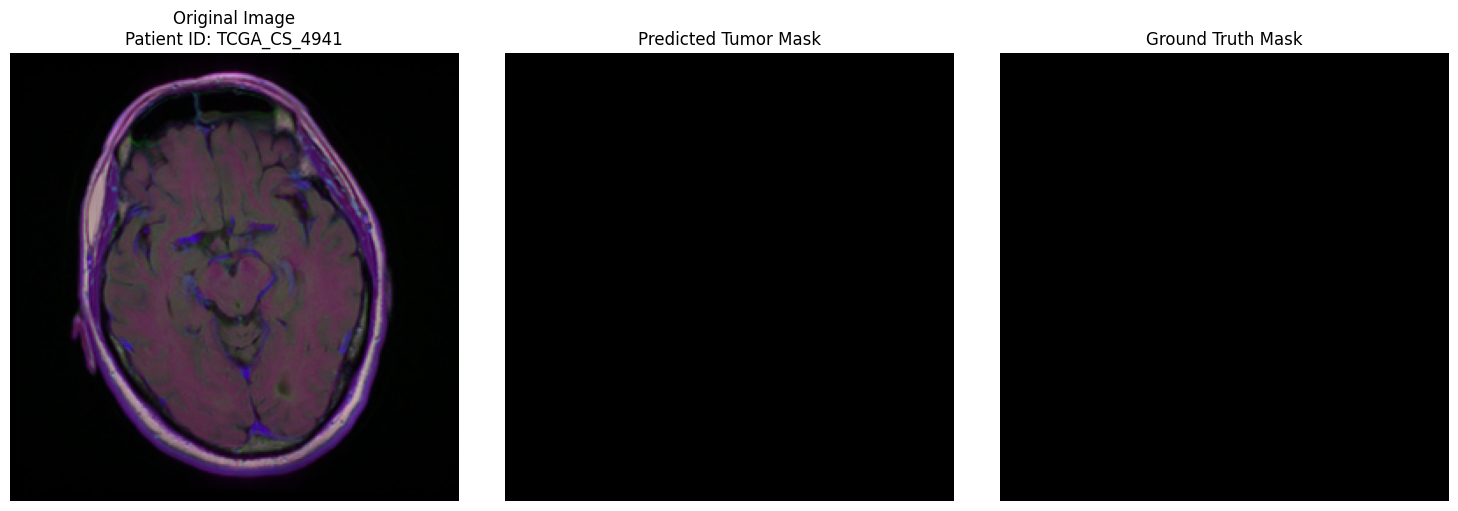

True Tumor Area for Patient ID TCGA_CS_4941: 0 pixels
Predicted Tumor Area for Patient ID TCGA_CS_4941: 0 pixels
IoU for Patient ID TCGA_CS_4941: 0.0000
Dice Coefficient for Patient ID TCGA_CS_4941: 0.0000
Accuracy for Patient ID TCGA_CS_4941: 1.0000


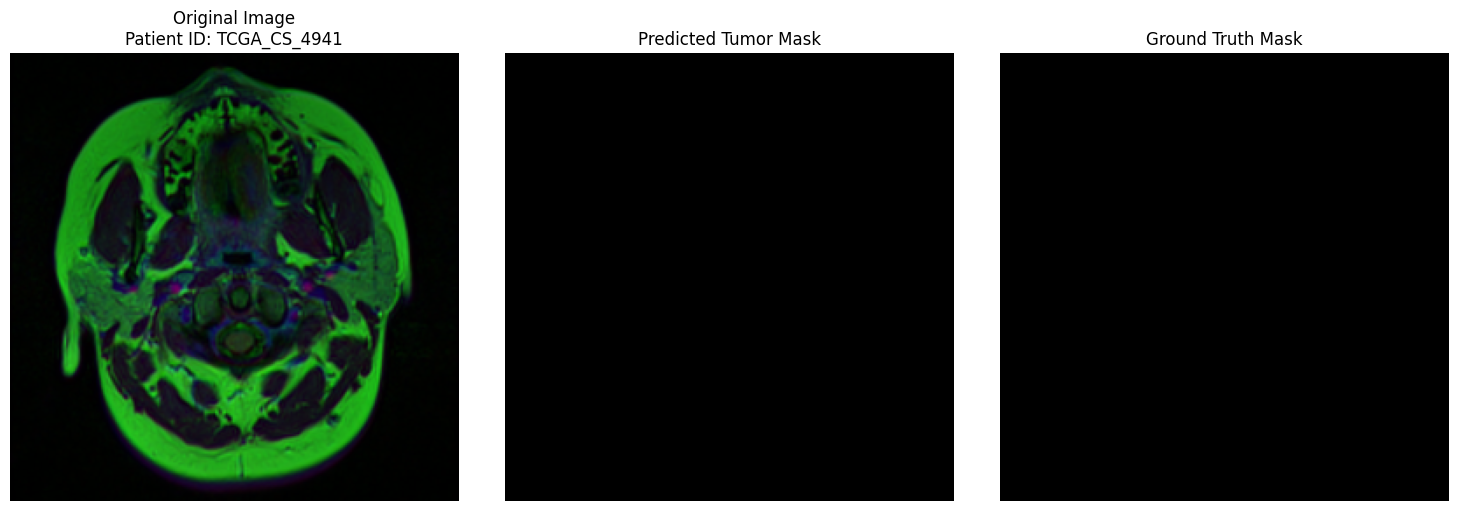

True Tumor Area for Patient ID TCGA_CS_4941: 2151 pixels
Predicted Tumor Area for Patient ID TCGA_CS_4941: 3141 pixels
IoU for Patient ID TCGA_CS_4941: 0.6369
Dice Coefficient for Patient ID TCGA_CS_4941: 0.7782
Accuracy for Patient ID TCGA_CS_4941: 0.9821


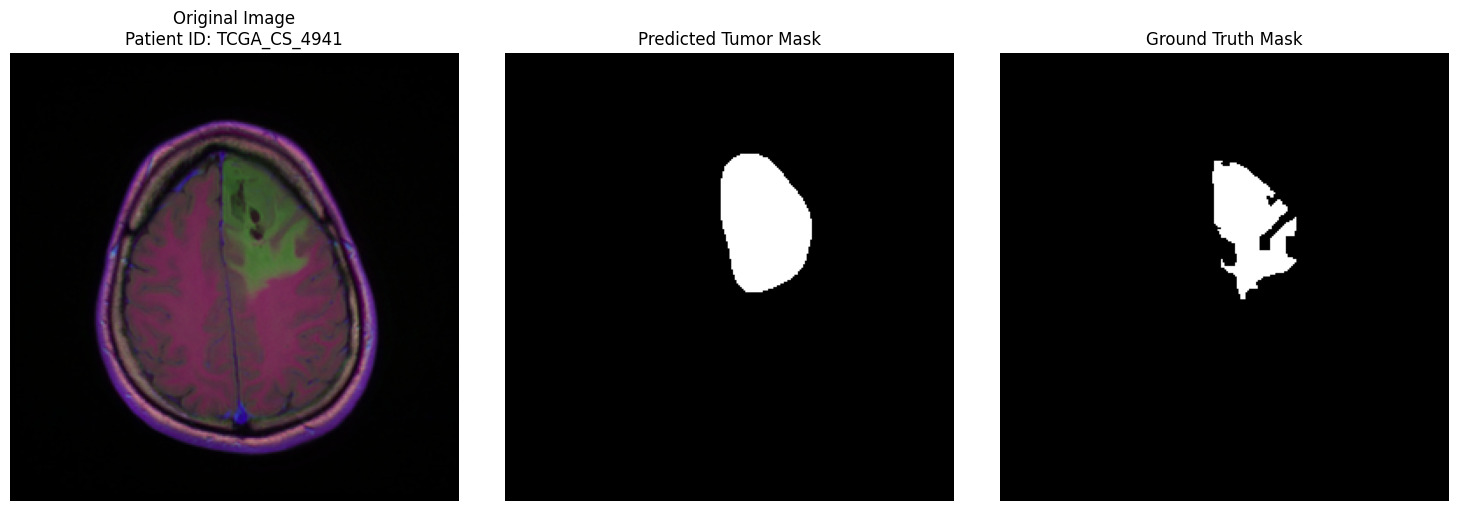

True Tumor Area for Patient ID TCGA_CS_4941: 0 pixels
Predicted Tumor Area for Patient ID TCGA_CS_4941: 0 pixels
IoU for Patient ID TCGA_CS_4941: 0.0000
Dice Coefficient for Patient ID TCGA_CS_4941: 0.0000
Accuracy for Patient ID TCGA_CS_4941: 1.0000


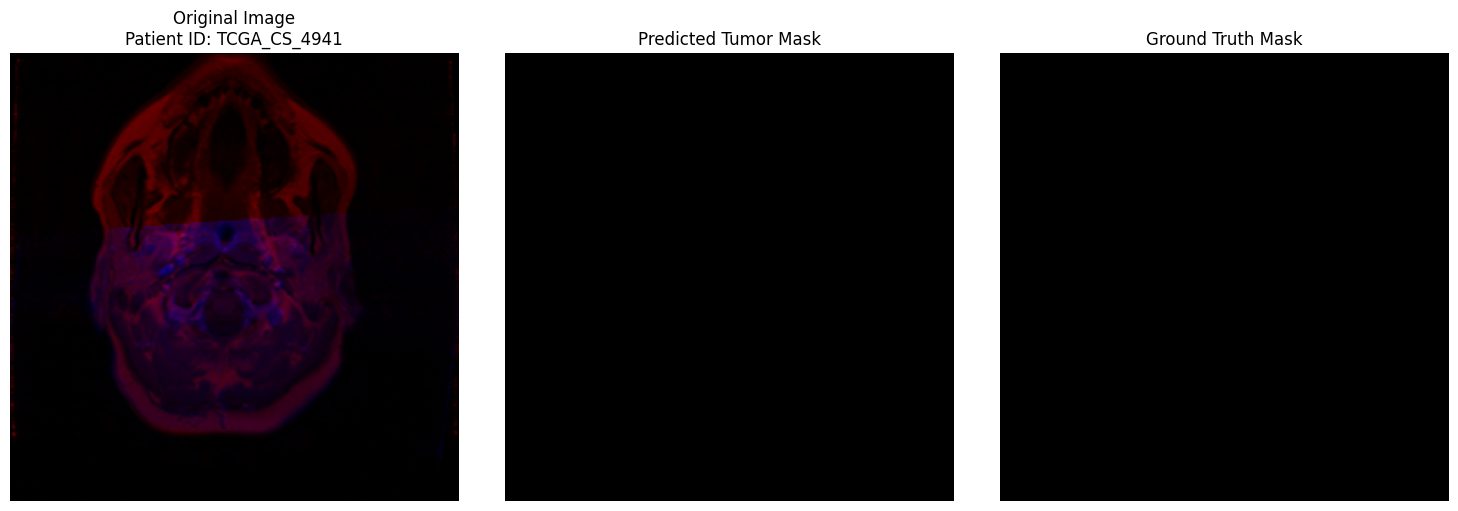

True Tumor Area for Patient ID TCGA_CS_4941: 3911 pixels
Predicted Tumor Area for Patient ID TCGA_CS_4941: 4068 pixels
IoU for Patient ID TCGA_CS_4941: 0.5329
Dice Coefficient for Patient ID TCGA_CS_4941: 0.6953
Accuracy for Patient ID TCGA_CS_4941: 0.9629


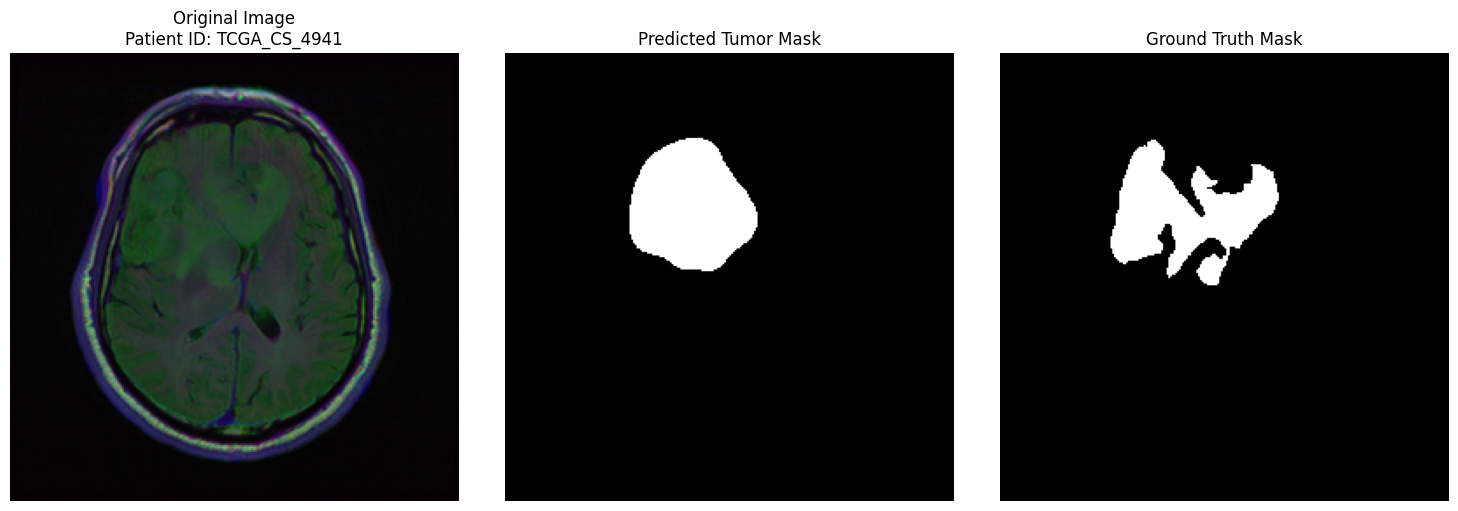

True Tumor Area for Patient ID TCGA_CS_4941: 0 pixels
Predicted Tumor Area for Patient ID TCGA_CS_4941: 0 pixels
IoU for Patient ID TCGA_CS_4941: 0.0000
Dice Coefficient for Patient ID TCGA_CS_4941: 0.0000
Accuracy for Patient ID TCGA_CS_4941: 1.0000


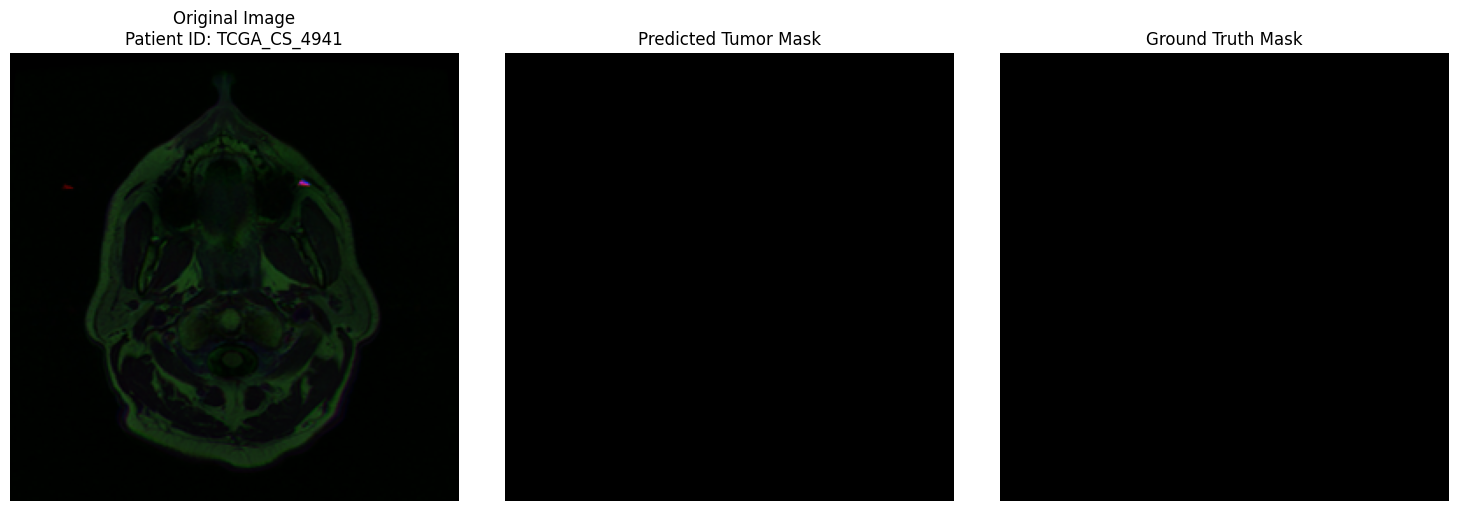

True Tumor Area for Patient ID TCGA_CS_4941: 0 pixels
Predicted Tumor Area for Patient ID TCGA_CS_4941: 0 pixels
IoU for Patient ID TCGA_CS_4941: 0.0000
Dice Coefficient for Patient ID TCGA_CS_4941: 0.0000
Accuracy for Patient ID TCGA_CS_4941: 1.0000


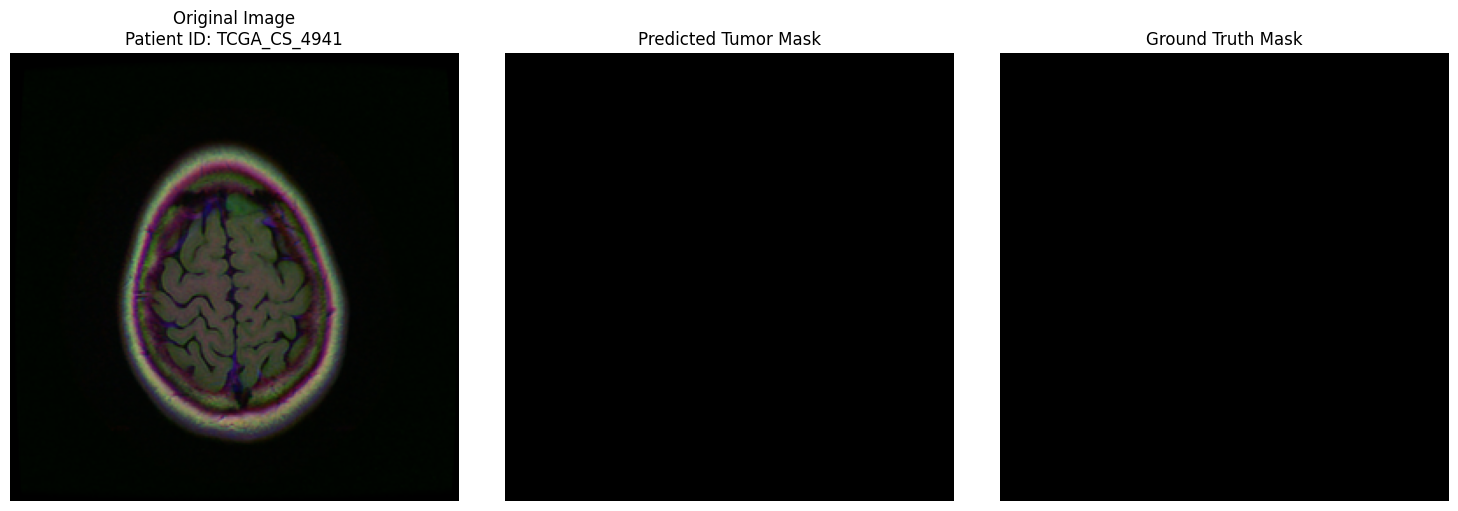

In [18]:
# Step 14. Visualize predictions, calculate more metrics for evaluation
#
# Required libraries
import matplotlib.pyplot as plt
import numpy as np

# Function to normalize image values
def normalize_image(image):
    if image.min() < 0:  # Check if the minimum value is negative
        image = (image + 1) / 2  # Shift and scale
    return image

# Thresholding function
def threshold_mask(mask, threshold=0.5):
    return (mask > threshold).astype(np.uint8)

# Accuracy metrics functions
def calculate_iou(true_mask, pred_mask):
    intersection = np.sum(true_mask * pred_mask)
    union = np.sum(true_mask) + np.sum(pred_mask) - intersection
    return intersection / union if union > 0 else 0.0

def calculate_dice(true_mask, pred_mask):
    intersection = np.sum(true_mask * pred_mask)
    return 2 * intersection / (np.sum(true_mask) + np.sum(pred_mask)) if (np.sum(true_mask) + np.sum(pred_mask)) > 0 else 0.0

def calculate_accuracy(true_mask, pred_mask):
    correct_pixels = np.sum(true_mask == pred_mask)
    total_pixels = true_mask.size
    return correct_pixels / total_pixels

# Visualization loop with accuracy metrics
for i, (image, pred_mask, true_mask, patient_id) in enumerate(zip(images, predicted_masks, masks, patient_ids)):
    if i < 9:  # Visualize only the first 9 images

        # Normalize image to be in the correct range
        try:
            img = normalize_image(image.cpu().permute(1, 2, 0).numpy())

            # Threshold the predicted mask
            pred_mask_np = threshold_mask(pred_mask.squeeze().cpu().numpy())

            # Calculate tumor area
            true_tumor_area = calculate_tumor_area(true_mask.squeeze().cpu().numpy())
            pred_tumor_area = calculate_tumor_area(pred_mask_np)

            # Calculate accuracy metrics
            iou = calculate_iou(true_mask.squeeze().cpu().numpy(), pred_mask_np)
            dice = calculate_dice(true_mask.squeeze().cpu().numpy(), pred_mask_np)
            accuracy = calculate_accuracy(true_mask.squeeze().cpu().numpy(), pred_mask_np)

            # Create a figure for plotting
            plt.figure(figsize=(15, 5))
        
            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(img, cmap='gray') 
            plt.title(f'Original Image\nPatient ID: {patient_id}')
            plt.axis('off')

            # Predicted mask
            plt.subplot(1, 3, 2)
            plt.imshow(pred_mask_np, cmap='gray', vmin=0, vmax=1)
            plt.title('Predicted Tumor Mask')
            plt.axis('off')

            # Ground truth mask
            true_mask_np = true_mask.squeeze().cpu().numpy()
            plt.subplot(1, 3, 3)
            plt.imshow(true_mask_np, cmap='gray', vmin=0, vmax=1)
            plt.title('Ground Truth Mask')
            plt.axis('off')

            # Show tumor areas
            print(f"True Tumor Area for Patient ID {patient_id}: {true_tumor_area} pixels")
            print(f"Predicted Tumor Area for Patient ID {patient_id}: {pred_tumor_area} pixels")
            print(f"IoU for Patient ID {patient_id}: {iou:.4f}")
            print(f"Dice Coefficient for Patient ID {patient_id}: {dice:.4f}")
            print(f"Accuracy for Patient ID {patient_id}: {accuracy:.4f}")

            # Show the plot
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error visualizing image {i + 1}: {e}")


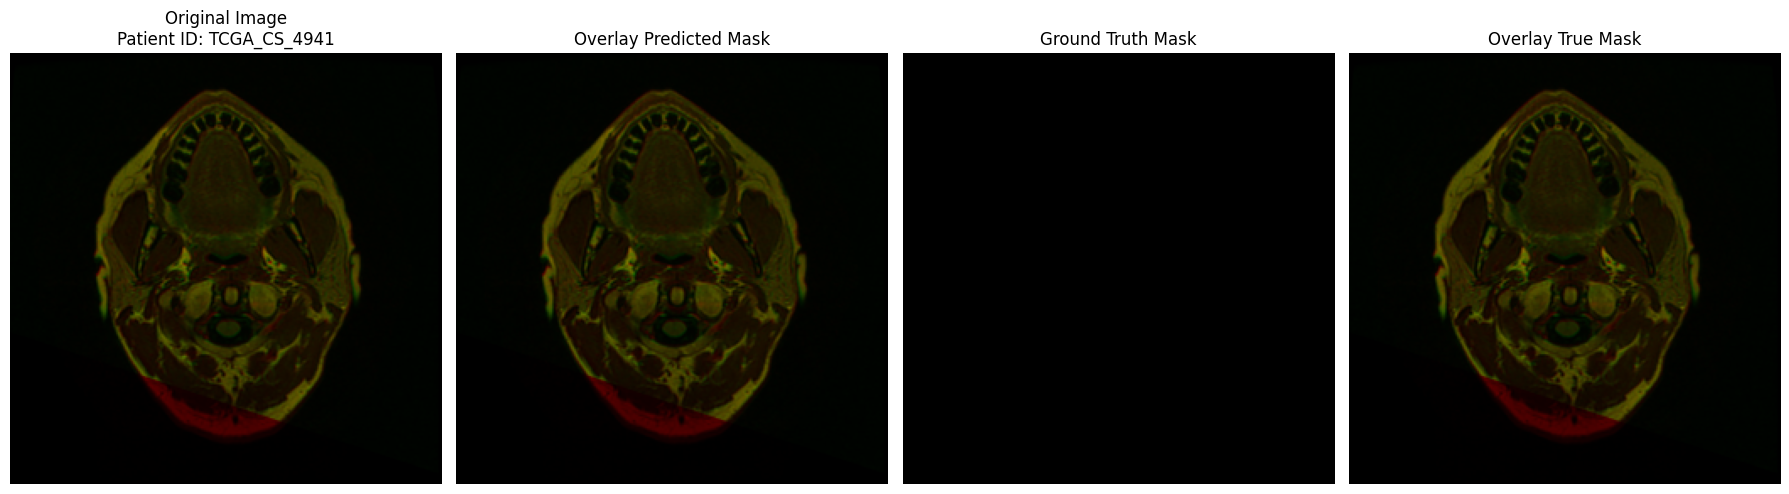

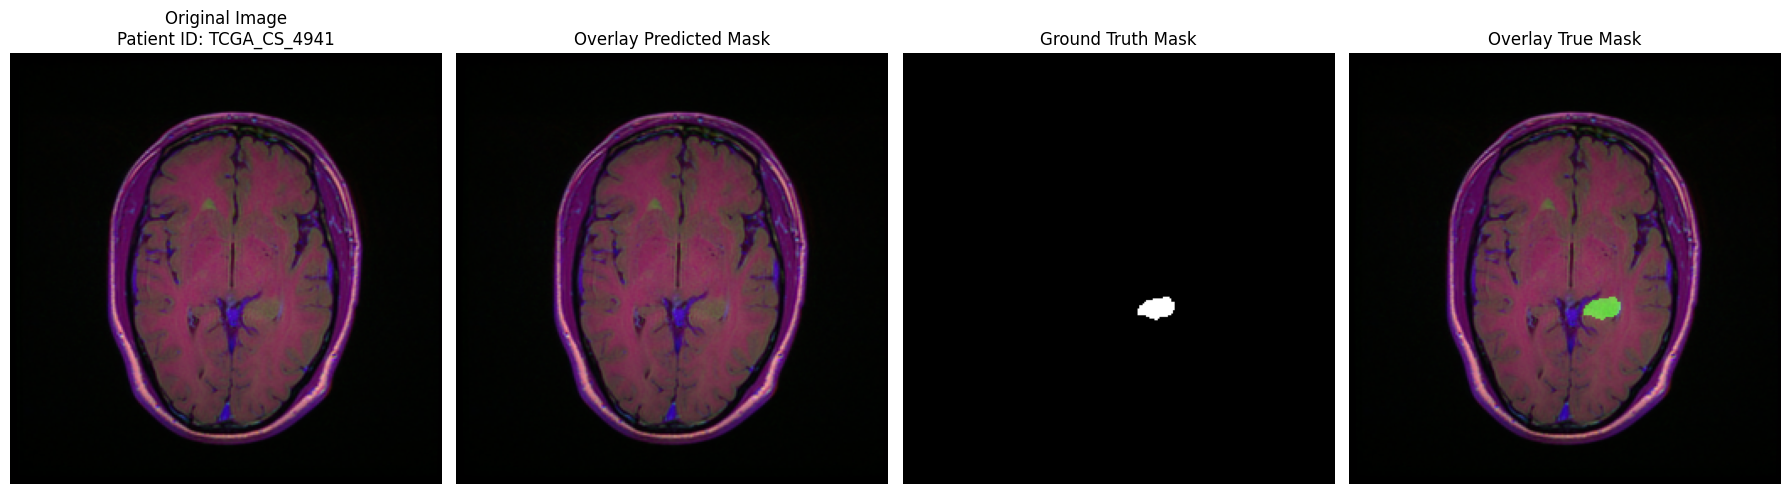

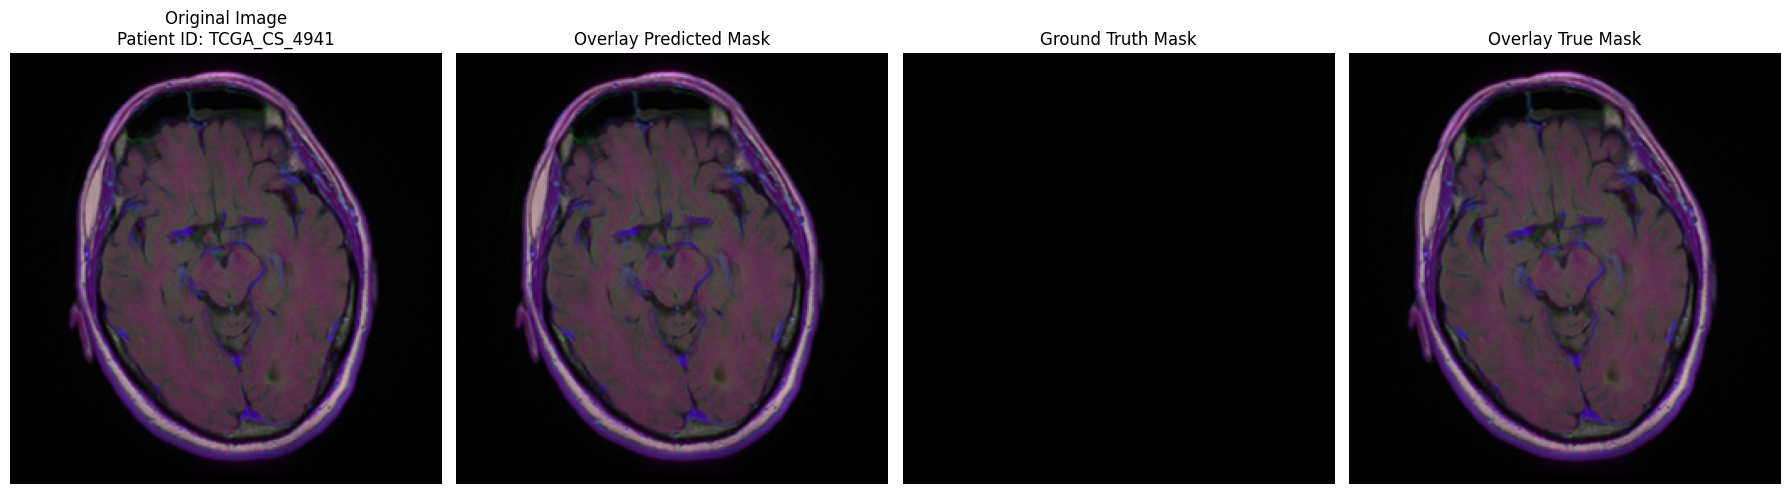

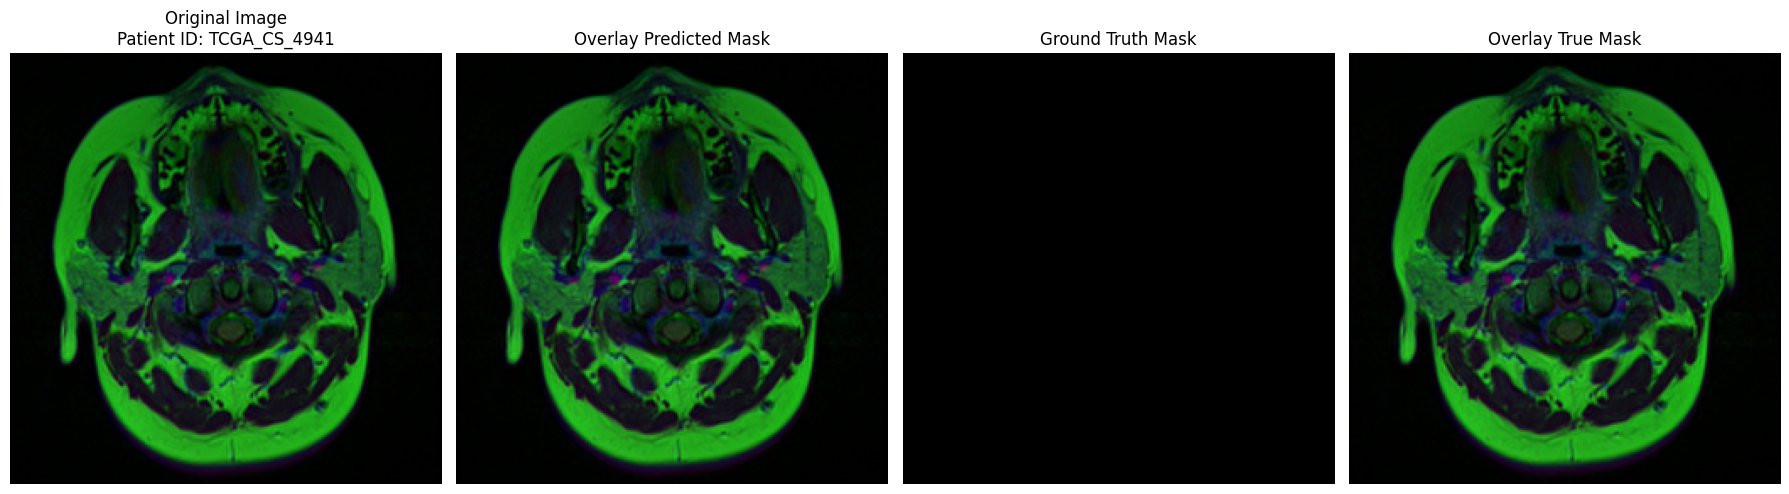

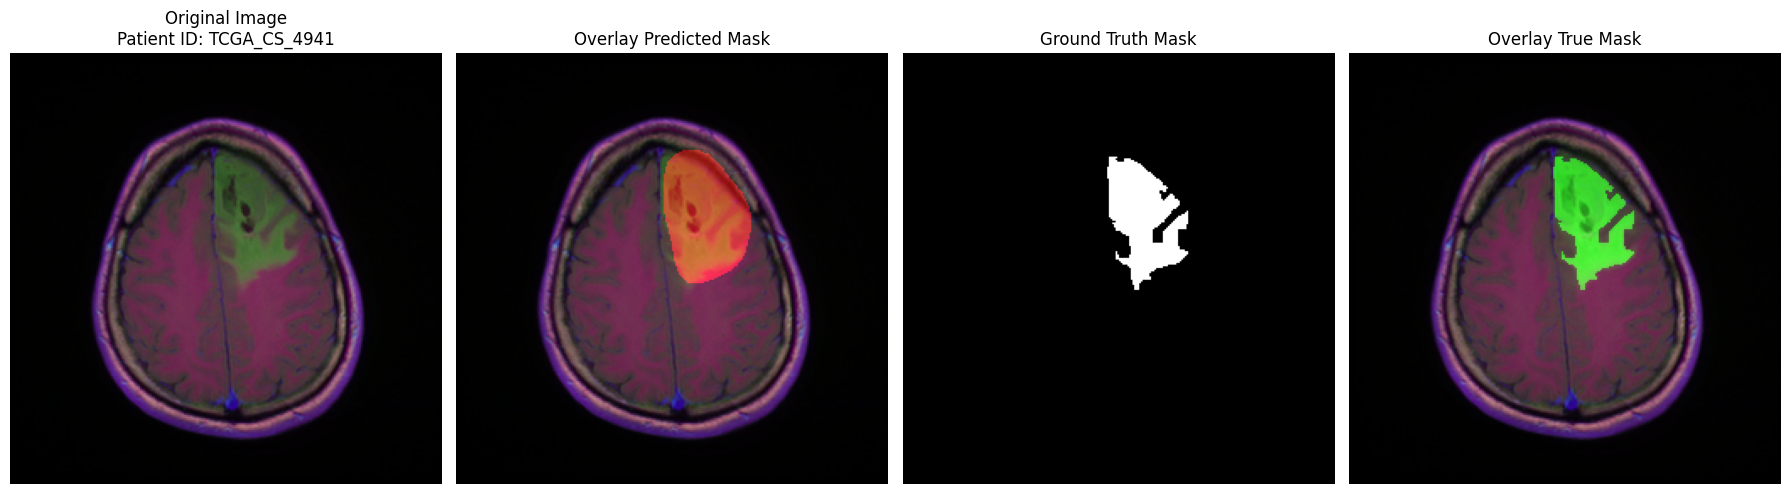

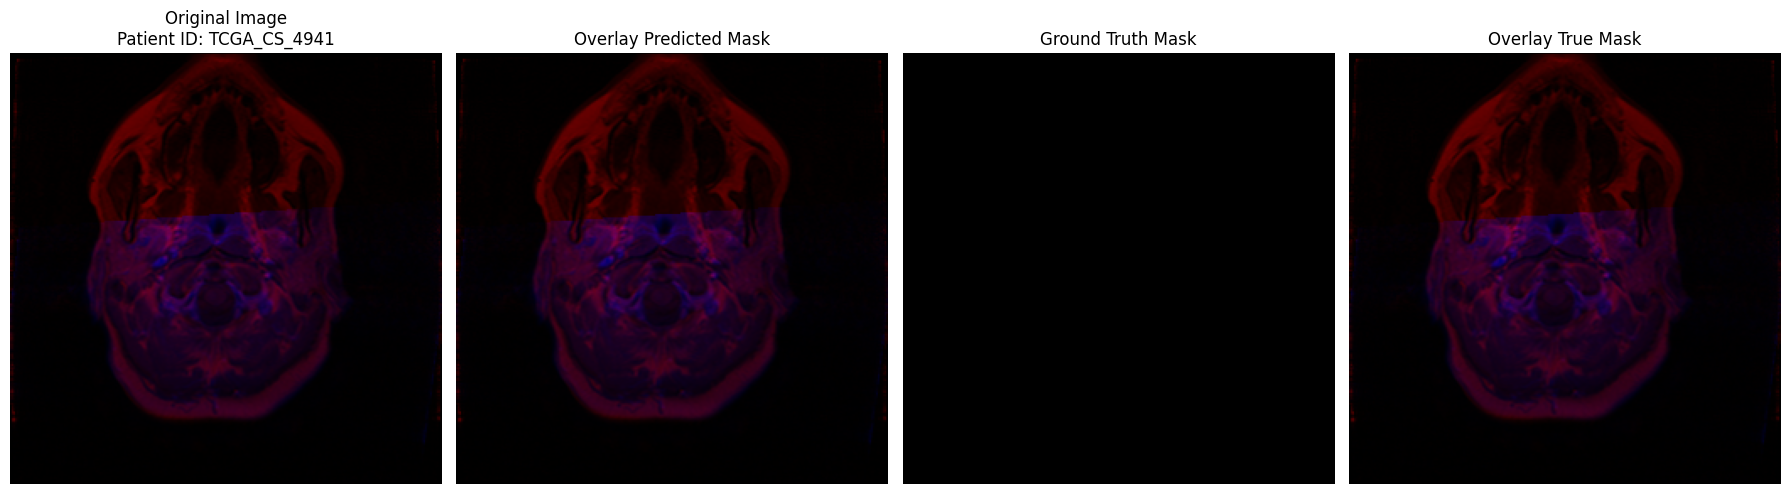

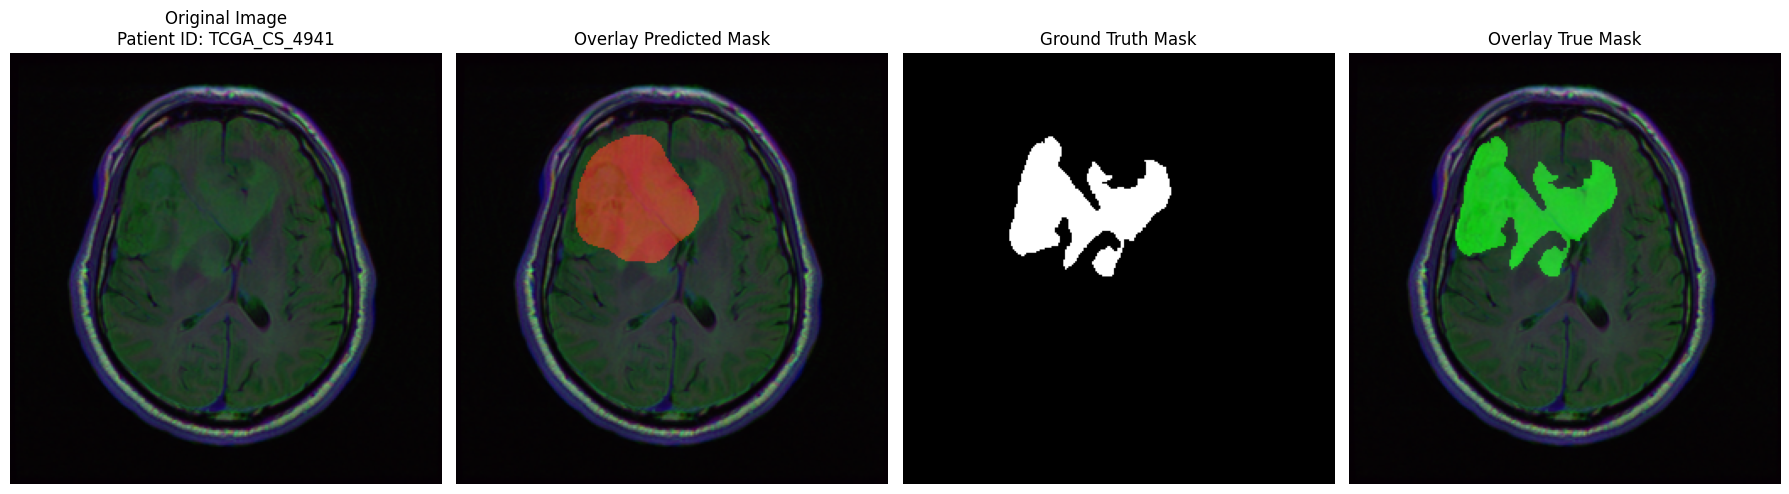

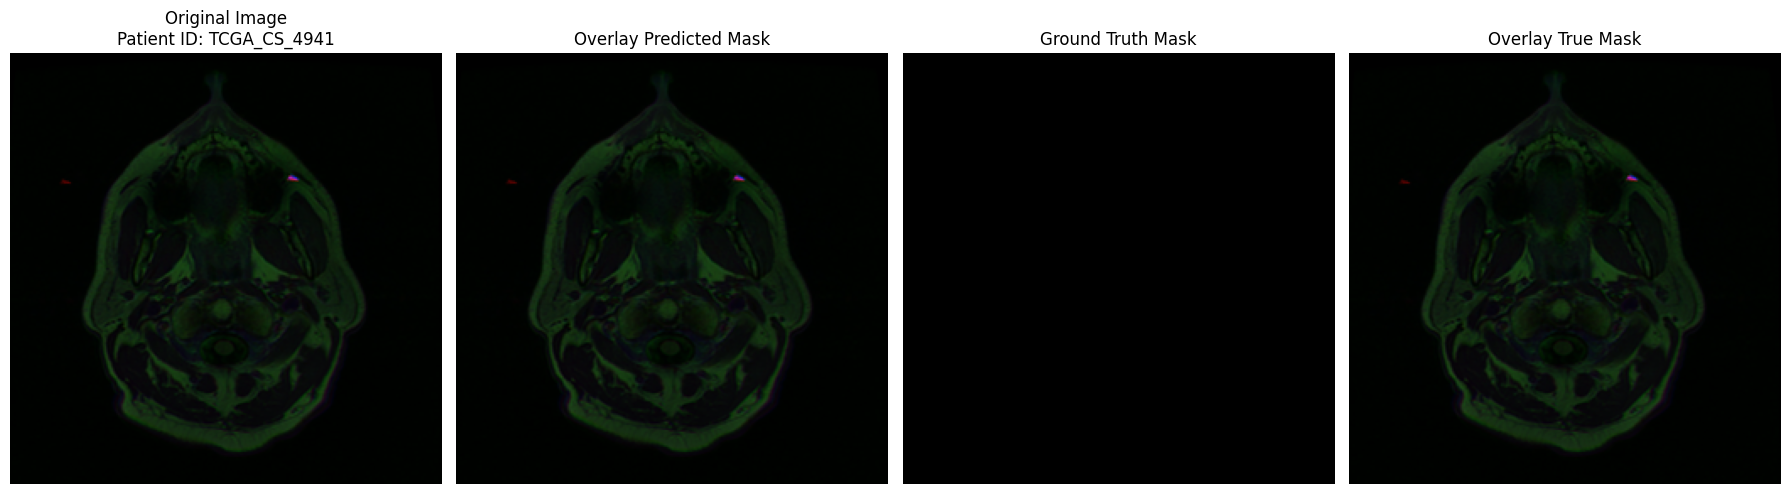

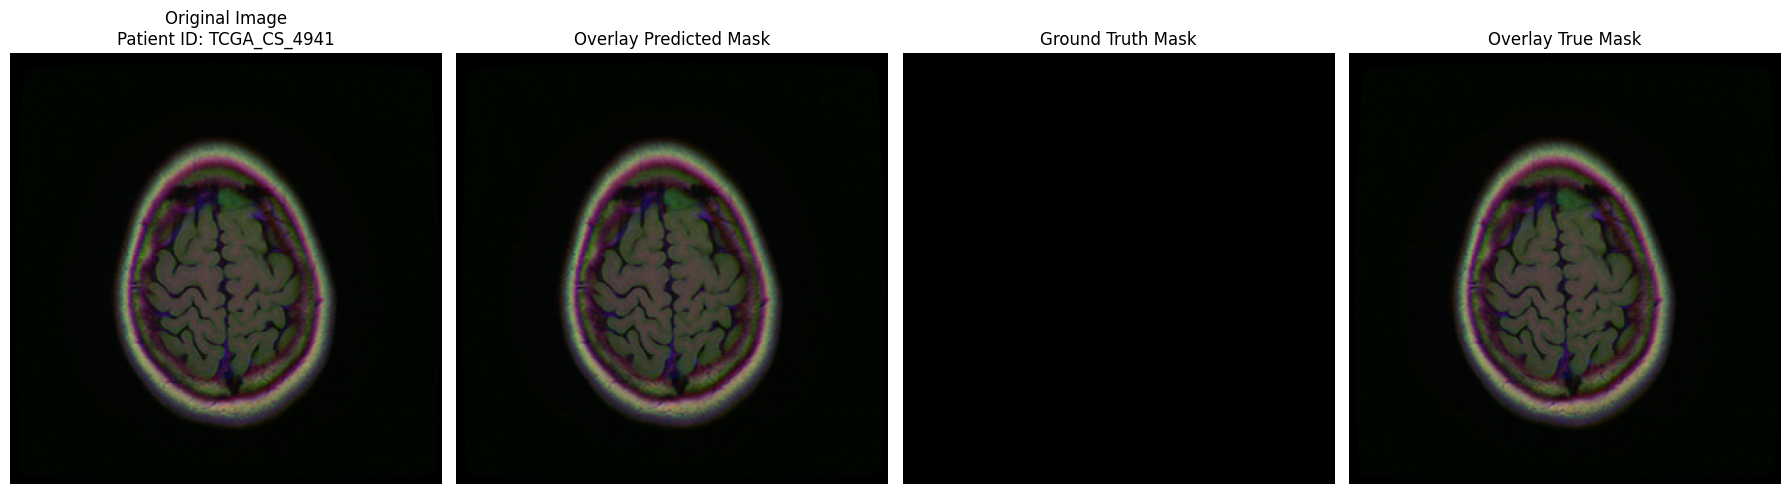

In [19]:
# Step 15. Visualize predictions more
#
# Required libraries
import matplotlib.pyplot as plt
import numpy as np

# Function to normalize image values
def normalize_image(image):
    if image.min() < 0:  # Check if the minimum value is negative
        image = (image + 1) / 2  # Shift and scale
    return image

# Thresholding function
def threshold_mask(mask, threshold=0.5):
    return (mask > threshold).astype(np.uint8)

# Overlay function
def overlay_mask(image, mask, color=(1, 0, 0), alpha=0.5):
    colored_mask = np.zeros_like(image)
    for c in range(3): 
        colored_mask[..., c] = mask * color[c]
    return np.clip(image + colored_mask * alpha, 0, 1)

# Accuracy metrics functions
def calculate_iou(true_mask, pred_mask):
    intersection = np.sum(true_mask * pred_mask)
    union = np.sum(true_mask) + np.sum(pred_mask) - intersection
    return intersection / union if union > 0 else 0.0

def calculate_dice(true_mask, pred_mask):
    intersection = np.sum(true_mask * pred_mask)
    return 2 * intersection / (np.sum(true_mask) + np.sum(pred_mask)) if (np.sum(true_mask) + np.sum(pred_mask)) > 0 else 0.0

def calculate_accuracy(true_mask, pred_mask):
    correct_pixels = np.sum(true_mask == pred_mask)
    total_pixels = true_mask.size
    return correct_pixels / total_pixels

# Visualization loop with accuracy metrics and overlay
for i, (image, pred_mask, true_mask, patient_id) in enumerate(zip(images, predicted_masks, masks, patient_ids)):
    if i < 9:  # Visualize only the first 9 images

        # Normalize image to be in the correct range
        try:
            img = normalize_image(image.cpu().permute(1, 2, 0).numpy())

            # Threshold the predicted mask
            pred_mask_np = threshold_mask(pred_mask.squeeze().cpu().numpy())

            # Calculate tumor area
            true_tumor_area = calculate_tumor_area(true_mask.squeeze().cpu().numpy())
            pred_tumor_area = calculate_tumor_area(pred_mask_np)

            # Calculate accuracy metrics
            iou = calculate_iou(true_mask.squeeze().cpu().numpy(), pred_mask_np)
            dice = calculate_dice(true_mask.squeeze().cpu().numpy(), pred_mask_np)
            accuracy = calculate_accuracy(true_mask.squeeze().cpu().numpy(), pred_mask_np)

            # Create a figure for plotting
            plt.figure(figsize=(18, 6))
        
            # Original image
            plt.subplot(1, 4, 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Original Image\nPatient ID: {patient_id}')
            plt.axis('off')

            # Overlay for predicted mask
            overlay_pred = overlay_mask(img, pred_mask_np, color=(1, 0, 0)) 
            plt.subplot(1, 4, 2)
            plt.imshow(overlay_pred)
            plt.title('Overlay Predicted Mask')
            plt.axis('off')

            # Ground truth mask
            true_mask_np = true_mask.squeeze().cpu().numpy()
            plt.subplot(1, 4, 3)
            plt.imshow(true_mask_np, cmap='gray', vmin=0, vmax=1)
            plt.title('Ground Truth Mask')
            plt.axis('off')

            # Overlay for true mask
            overlay_true = overlay_mask(img, true_mask_np, color=(0, 1, 0)) 
            plt.subplot(1, 4, 4)
            plt.imshow(overlay_true)
            plt.title('Overlay True Mask')
            plt.axis('off')

            # Show the plot
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error visualizing image {i + 1}: {e}")


In [20]:
# Step 16. Final evaluation with more metrics
#
# Required libraries
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the Dice Coefficient
def dice_coefficient(pred_mask, true_mask, threshold=0.5):
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum()
    if union == 0:
        return 1.0  # Both masks are empty
    dice = (2. * intersection) / union
    return dice.item()

# Function to calculate Accuracy
def accuracy(pred_mask, true_mask):
    total_pixels = pred_mask.numel()  # Total number of pixels
    correct_pixels = (pred_mask == true_mask).sum().item()  # Correctly predicted pixels
    acc = correct_pixels / total_pixels
    return acc

# Function to calculate Jaccard Index (IoU)
def jaccard_index(pred_mask, true_mask):
    intersection = (pred_mask * true_mask).sum().item()
    union = (pred_mask + true_mask).clamp(0, 1).sum().item()  # Union of both masks
    if union == 0:
        return 1.0  # Both masks are empty
    iou = intersection / union
    return iou

# Initialize lists to store metrics
predicted_areas = []
true_areas = []
dice_scores = []
accuracies = []
jaccard_indices = []

# Evaluate on test data and calculate both predicted and true tumor areas
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.cuda()
        outputs = model(images)
        predicted_masks = torch.sigmoid(outputs).cpu()  # Apply sigmoid and move to CPU for processing
        
        for i, (pred_mask, true_mask) in enumerate(zip(predicted_masks, masks)):
            # Binarize the predicted and true masks (threshold = 0.5)
            pred_mask = (pred_mask > 0.5).float()
            true_mask = (true_mask > 0.5).float()
            
            # Calculate tumor areas
            predicted_tumor_area = calculate_tumor_area(pred_mask)
            true_tumor_area = calculate_tumor_area(true_mask)
            predicted_areas.append(predicted_tumor_area)
            true_areas.append(true_tumor_area)

            # Calculate Dice score
            dice_score = dice_coefficient(pred_mask, true_mask)
            dice_scores.append(dice_score)
            
            # Calculate Accuracy
            acc = accuracy(pred_mask, true_mask)
            accuracies.append(acc)
            
            # Calculate Jaccard Index (IoU)
            iou = jaccard_index(pred_mask, true_mask)
            jaccard_indices.append(iou)

            # Print metrics for each image
            print(f"Image {i + 1}: Predicted Tumor Area = {predicted_tumor_area} pixels, True Tumor Area = {true_tumor_area} pixels")
            print(f"Image {i + 1}: Dice Coefficient = {dice_score:.4f}, Accuracy = {acc:.4f}, Jaccard Index = {iou:.4f}")

# Convert lists to numpy arrays for easier calculations
predicted_areas = np.array(predicted_areas)
true_areas = np.array(true_areas)
dice_scores = np.array(dice_scores)
accuracies = np.array(accuracies)
jaccard_indices = np.array(jaccard_indices)

# Calculate accuracy metrics
mae = np.mean(np.abs(predicted_areas - true_areas))  # Mean Absolute Error
mse = np.mean((predicted_areas - true_areas) ** 2)  # Mean Squared Error
r_squared = 1 - (np.sum((predicted_areas - true_areas) ** 2) / np.sum((true_areas - np.mean(true_areas)) ** 2))  # R-squared
average_dice = np.mean(dice_scores)
average_acc = np.mean(accuracies)
average_iou = np.mean(jaccard_indices)

# Print accuracy metrics
print(f"\nMean Absolute Error (MAE): {mae:.2f} pixels")
print(f"Mean Squared Error (MSE): {mse:.2f} pixels")
print(f"R-squared Score: {r_squared:.4f}")
print(f"Average Dice Coefficient: {average_dice:.4f}")
print(f"Average Accuracy: {average_acc:.4f}")
print(f"Average Jaccard Index (IoU): {average_iou:.4f}")


Image 1: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 1: Dice Coefficient = 1.0000, Accuracy = 1.0000, Jaccard Index = 1.0000
Image 2: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 2: Dice Coefficient = 1.0000, Accuracy = 1.0000, Jaccard Index = 1.0000
Image 3: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 3: Dice Coefficient = 1.0000, Accuracy = 1.0000, Jaccard Index = 1.0000
Image 4: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 4: Dice Coefficient = 1.0000, Accuracy = 1.0000, Jaccard Index = 1.0000
Image 5: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 5: Dice Coefficient = 1.0000, Accuracy = 1.0000, Jaccard Index = 1.0000
Image 6: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 6: Dice Coefficient = 1.0000, Accuracy = 1.0000, Jaccard Index = 1.0000
Image 7: Predicted Tumor Area = 0 pixels, True Tumor Area = 0 pixels
Image 7: Dice Coefficient = 1.0000, Accuracy = 1.